In [1]:
import sys,os
import trimesh as tri
import numpy as np
import torch

from utils import mesh_processing, lddmm_utils

GPU = True
device_idx = 0
torch.cuda.get_device_name(device_idx)

if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
cuda:0


In [2]:
root_path = "../datasets/COMA/"

idents = ['FaceTalk_170725_00137_TA', 'FaceTalk_170728_03272_TA', 'FaceTalk_170731_00024_TA', 'FaceTalk_170809_00138_TA',
          'FaceTalk_170811_03274_TA', 'FaceTalk_170811_03275_TA', 'FaceTalk_170904_00128_TA', 'FaceTalk_170904_03276_TA',
          'FaceTalk_170908_03277_TA', 'FaceTalk_170912_03278_TA', 'FaceTalk_170913_03279_TA', 'FaceTalk_170915_00223_TA']

exprs = ['bareteeth', 'cheeks_in', 'eyebrow', 'high_smile', 'lips_back', 'lips_up',
         'mouth_down', 'mouth_extreme', 'mouth_middle', 'mouth_open', 'mouth_side', 'mouth_up']

In [3]:
path_id1_expr1 = root_path + idents[0] + '/' + exprs[0]
list_id1_expr1 = os.listdir(path_id1_expr1)
list_id1_expr1.sort()

path_id2_expr1 = root_path + idents[1] + '/' + exprs[0]
list_id2_expr1 = os.listdir(path_id2_expr1)
list_id2_expr1.sort()

path_id3_expr1 = root_path + idents[2] + '/' + exprs[0]
list_id3_expr1 = os.listdir(path_id3_expr1)
list_id3_expr1.sort()

In [4]:
id1_neutral = tri.load(path_id1_expr1 + '/' + list_id1_expr1[0])
id1_expr1 = tri.load(path_id1_expr1 + '/' + list_id1_expr1[len(list_id1_expr1)//2])

id2_neutral = tri.load(path_id2_expr1 + '/' + list_id2_expr1[0])
id2_expr1 = tri.load(path_id2_expr1 + '/' + list_id2_expr1[len(list_id2_expr1)//2])

id3_neutral = tri.load(path_id3_expr1 + '/' + list_id3_expr1[0])
id3_expr1 = tri.load(path_id3_expr1 + '/' + list_id3_expr1[len(list_id3_expr1)//2])

In [5]:
def varifold_dist(mesh1, mesh2, sigma):
    torchdtype = torch.float
    #sig=[2,1,0.5,0.2,0.1,0.08,0.05,0.02,0.01,0.005]
    #for i,sigma in enumerate(sig):
    #    sig[i] = torch.tensor([sigma], dtype=torchdtype, device=device)
    
    sigma = torch.tensor([sigma], dtype=torchdtype, device=device)
    
    # PyKeOps counterpart
    KeOpsdeviceId = device.index  # id of Gpu device (in case Gpu is  used)
    KeOpsdtype = torchdtype.__str__().split(".")[1]  # 'float32'
    
    V1, F1 = torch.Tensor(mesh1.vertices).to(dtype=torchdtype, device=device).requires_grad_(True), torch.Tensor(mesh1.faces).to(dtype=torch.int32, device=device)
    V2, F2 = torch.Tensor(mesh2.vertices).to(dtype=torchdtype, device=device).requires_grad_(True), torch.Tensor(mesh2.faces).to(dtype=torch.int32, device=device)
    L = torch.Tensor([0.]).to(device)
    #for sigma in sig:
    L += lddmm_utils.lossVarifoldSurf(F1, V2, F2,lddmm_utils.GaussLinKernel_current(sigma=sigma))(V1)

        #reg = (lddmm_utils.VarifoldSurfPS(F1, V_template, F1,lddmm_utils.GaussSquaredKernel_varifold_unoriented(sigma=sig[4]))(V1) - lddmm_utils.VarifoldSurfPS(F2, V_template, F2,lddmm_utils.GaussSquaredKernel_varifold_unoriented(sigma=sig[4]))(V2)).abs()
    
    return L.item()

In [6]:
varifold_dist(id1_expr1, id2_expr1, sigma = 0.1)

5.2098650485277176e-05

## Distance matrix

In [7]:
def load(ident, expr, neutral=False):
    path_id_expr = root_path + ident + '/' + expr
    list_id_expr = os.listdir(path_id_expr)
    list_id_expr.sort()
    if neutral:
        return(tri.load(path_id_expr + '/' + list_id_expr[0]))
    
    return(tri.load(path_id_expr + '/' + list_id_expr[len(list_id_expr)//2]))

In [8]:
meshes = []
for ident in idents:
    #expressions = []
    for nb, expr in enumerate(exprs):
        if nb==0:
            meshes.append(load(ident,expr, neutral=True))
        meshes.append(load(ident,expr))

In [9]:
expr_test = meshes[:12]

In [10]:
from tqdm import tqdm

sigma_id=0.08

distances =[]
for i, m in enumerate(tqdm(meshes)):
    dist = []
    k = i
    while k<len(meshes):
        dist.append(varifold_dist(m, meshes[k], sigma=sigma_id))
        
        k += 1
    distances.append(dist)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


In [11]:
sigma_expr=0.02

distances_expr_test = []
for i, m in enumerate(tqdm(expr_test)):
    dist = []
    k = i
    while k<len(expr_test):
        dist.append(varifold_dist(m, expr_test[k], sigma=sigma_expr))
        
        k += 1
    distances_expr_test.append(dist)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 69.28it/s]


In [12]:
mat = []
for i, elt in enumerate(distances):
    A = np.array(distances[i])
    mat.append(np.pad(A,(len(distances[0])-len(distances[i]),0),'constant')) 
mat = np.array(mat)

mat_expr_test = []
for i, elt in enumerate(distances_expr_test):
    A = np.array(distances_expr_test[i])
    mat_expr_test.append(np.pad(A,(len(distances_expr_test[0])-len(distances_expr_test[i]),0),'constant')) 
mat_expr_test = np.array(mat_expr_test)

In [13]:
import matplotlib.pyplot as plt

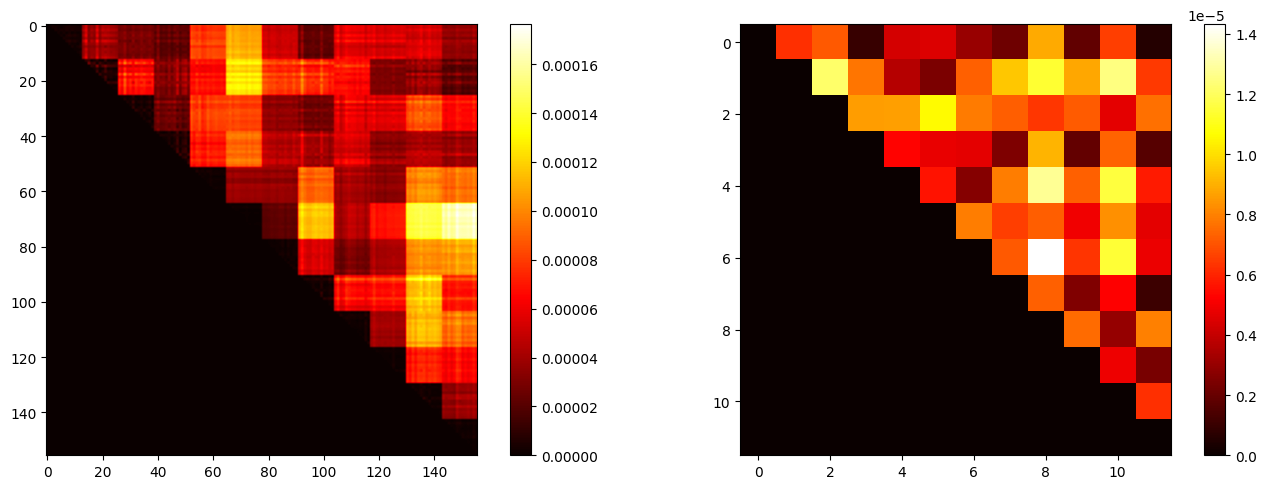

In [14]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.imshow(mat, cmap='hot')
plt.colorbar()

plt.subplot(122)
plt.imshow(mat_expr_test, cmap='hot')
plt.colorbar()

plt.tight_layout()
plt.show()

In [15]:
mat_full = np.copy(mat)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        if j<i:
            mat_full[i,j]=mat[j,i]
            

In [16]:
def euclidean_dist(mesh1, mesh2):
    return(np.linalg.norm(mesh1.vertices - mesh2.vertices))

In [17]:
distances_eucl =[]
for i, m in enumerate(tqdm(meshes)):
    dist = []
    k = i
    while k<len(meshes):
        dist.append(euclidean_dist(m, meshes[k]))
        
        k += 1
    distances_eucl.append(dist)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 556.12it/s]


In [18]:
mat_eucl = []
for i, elt in enumerate(distances_eucl):
    A = np.array(distances_eucl[i])
    mat_eucl.append(np.pad(A,(len(distances_eucl[0])-len(distances_eucl[i]),0),'constant')) 
mat_eucl = np.array(mat_eucl)

mat_full_eucl = np.copy(mat_eucl)
for i in range(mat_eucl.shape[0]):
    for j in range(mat_eucl.shape[1]):
        if j<i:
            mat_full_eucl[i,j]=mat_eucl[j,i]
            

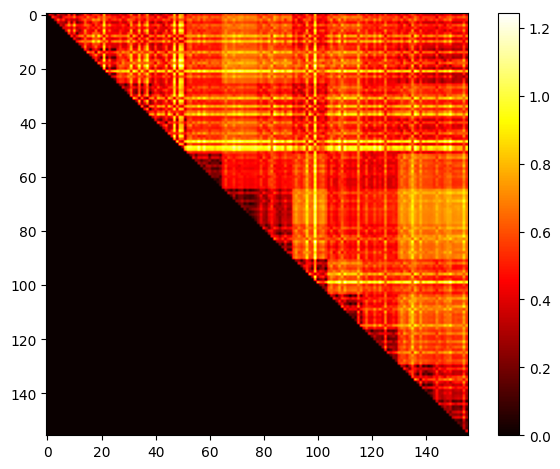

In [19]:
plt.imshow(mat_eucl, cmap='hot')
plt.colorbar()
plt.tight_layout()
plt.show()

In [20]:
def chamfer_dist(mesh1, mesh2):
    from chamfer_distance import ChamferDistance as chamfer_dist
    V1, V2 = torch.Tensor(mesh1.vertices), torch.Tensor(mesh2.vertices)
    
    return chamfer_dist(V1,V2)[0]

distances_chamf =[]
for i, m in enumerate(tqdm(meshes)):
    dist = []
    k = i
    while k<len(meshes):
        dist.append(chamfer_dist(m, meshes[k]))
        
        k += 1
    distances_chamf.append(dist)

mat_chamf = []
for i, elt in enumerate(distances_chamf):
    A = np.array(distances_chamf[i])
    mat_chamf.append(np.pad(A,(len(distances_chamf[0])-len(distances_chamf[i]),0),'constant')) 
mat_chamf = np.array(mat_chamf)

mat_full_chamf = np.copy(mat_chamf)
for i in range(mat_chamf.shape[0]):
    for j in range(mat_chamf.shape[1]):
        if j<i:
            mat_full_chamf[i,j]=mat_chamf[j,i]

plt.imshow(mat_chamf, cmap='hot')
plt.colorbar()
plt.tight_layout()
plt.show()

## Plotting relative "positions" in shape space measured with geometric measure

In [28]:
D = mat_full #Dissimilarity matrix
m = np.ones(shape=(len(D),1))*(1/len(D))

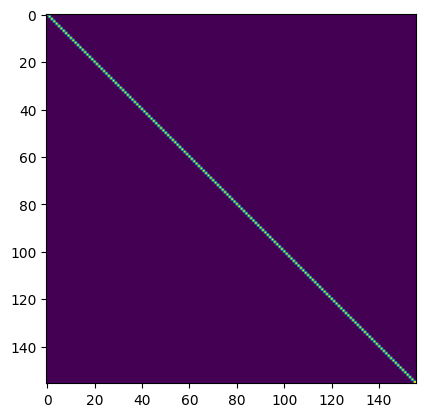

In [29]:
C = np.identity(n=len(m)) - np.full(shape=(len(m),len(m)),fill_value=m) #Centering matrix
plt.imshow(C)

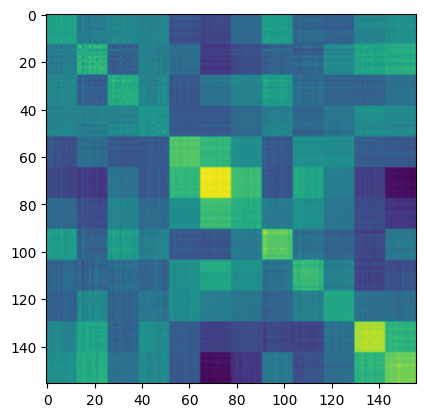

In [30]:
S = -0.5*np.matmul(C,np.matmul(D,np.transpose(C)))
C = np.identity(n=len(m)) - np.full(shape=(len(m),len(m)),fill_value=m)
plt.imshow(S)

In [31]:
eigen = np.linalg.eig(S) #Eigenvalue decomposition

U = eigen[1]
Lambda = np.where(eigen[0]<=0,0,eigen[0])

In [32]:
scores = np.matmul(np.sqrt(np.linalg.inv(np.diag(m[:,0]))),np.matmul(U,np.sqrt(np.diag(Lambda))))

(156, 156)

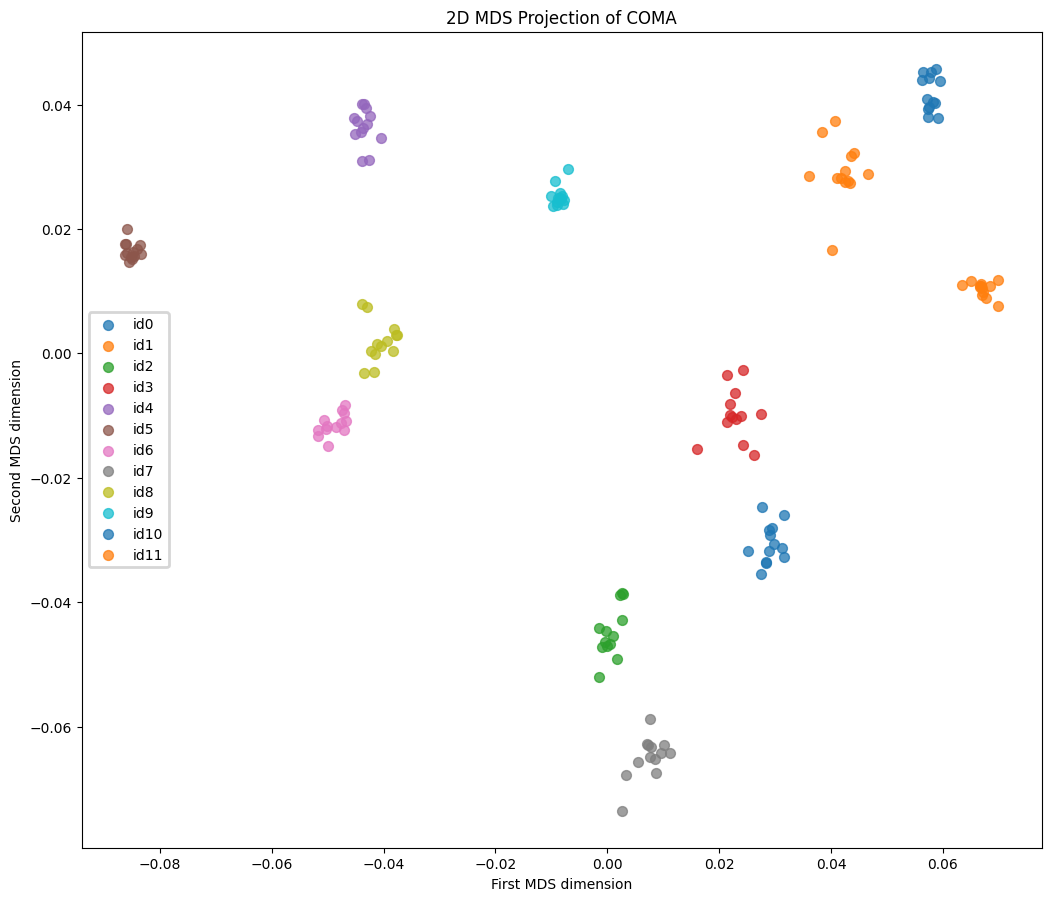

In [33]:
x_proj = scores[:,0]
y_proj = scores[:,1]

#plt.style.use('ggplot')
fig1 = plt.figure()

split_x = np.array_split(x_proj, 12)
split_y = np.array_split(y_proj, 12)
for i in range(len(split_x)):
    plt.scatter(split_x[i],split_y[i], label='id'+str(i),s=50,alpha=0.75)

#for i, txt in enumerate(cities):
    #plt.annotate(txt, (x_proj[i]+0.05, y_proj[i]+0.1), size=12, style='italic')

plt.title('2D MDS Projection of COMA')
plt.xlabel('First MDS dimension',size=10)
plt.ylabel('Second MDS dimension',size=10)
legend = plt.legend(loc = 'center left'); legend.get_frame().set_linewidth(2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.7, wspace=0.5, hspace=0.3)
plt.show()

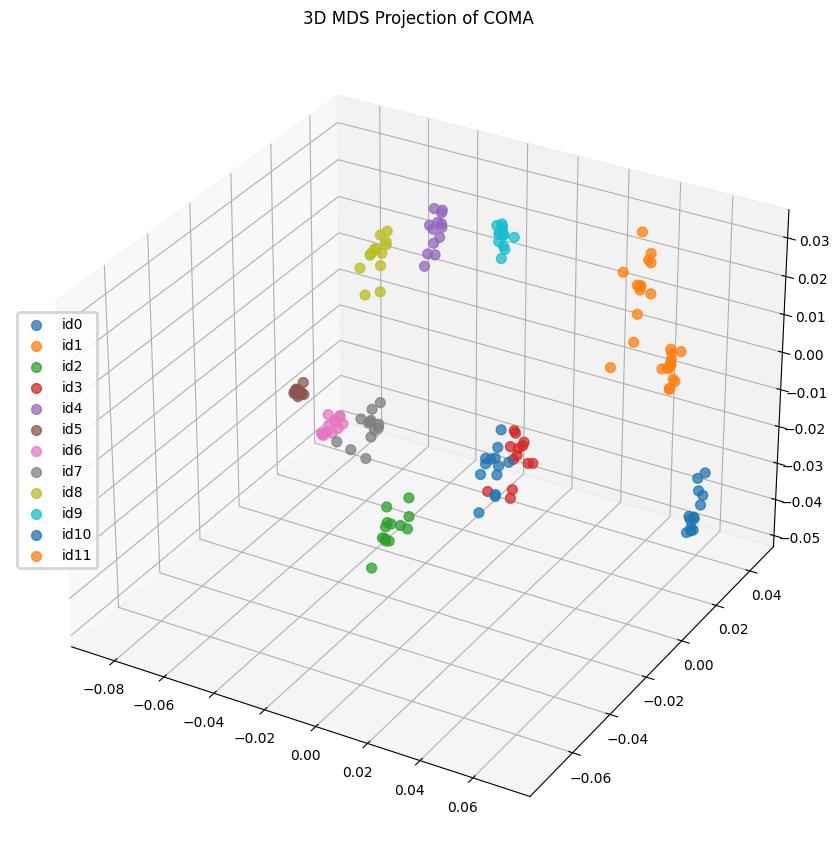

In [40]:
x_proj = scores[:,0]
y_proj = scores[:,1]
z_proj = scores[:,2]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')

split_x = np.array_split(x_proj, 12)
split_y = np.array_split(y_proj, 12)
split_z = np.array_split(z_proj, 12)

for i in range(len(split_x)):
    ax1.scatter(split_x[i],split_y[i], split_z[i], label='id'+str(i),s=50,alpha=0.75)
    

plt.title('3D MDS Projection of COMA')
legend = plt.legend(loc = 'center left'); legend.get_frame().set_linewidth(2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.7, wspace=0.5, hspace=0.3)
plt.show()

## With euclidean metric

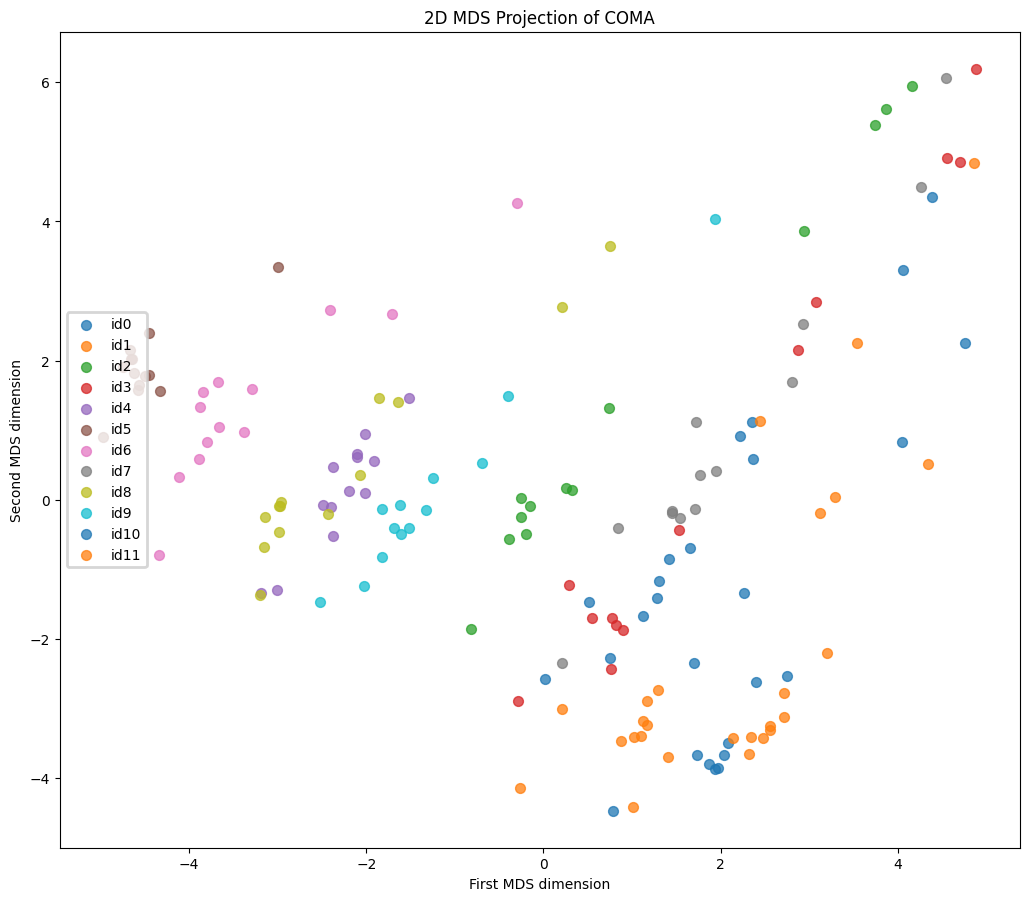

In [27]:
D = mat_full_eucl #Dissimilarity matrix
m = np.ones(shape=(len(D),1))*(1/len(D))

C = np.identity(n=len(m)) - np.full(shape=(len(m),len(m)),fill_value=m) #Centering matrix

S = -0.5*np.matmul(C,np.matmul(D,np.transpose(C)))
C = np.identity(n=len(m)) - np.full(shape=(len(m),len(m)),fill_value=m)

eigen = np.linalg.eig(S) #Eigenvalue decomposition

U = eigen[1]
Lambda = np.where(eigen[0]<=0,0,eigen[0])

scores = np.matmul(np.sqrt(np.linalg.inv(np.diag(m[:,0]))),np.matmul(U,np.sqrt(np.diag(Lambda))))

x_proj = scores[:,0]
y_proj = scores[:,1]

#plt.style.use('ggplot')
fig1 = plt.figure()

split_x = np.array_split(x_proj, 12)
split_y = np.array_split(y_proj, 12)
for i in range(len(split_x)):
    plt.scatter(split_x[i],split_y[i], label='id'+str(i),s=50,alpha=0.75)

#for i, txt in enumerate(cities):
    #plt.annotate(txt, (x_proj[i]+0.05, y_proj[i]+0.1), size=12, style='italic')

plt.title('2D MDS Projection of COMA')
plt.xlabel('First MDS dimension',size=10)
plt.ylabel('Second MDS dimension',size=10)
legend = plt.legend(loc = 'center left'); legend.get_frame().set_linewidth(2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.7, wspace=0.5, hspace=0.3)
plt.show()